In [ ]:
import kagglehub
abdelhamed1_london_house_price_data_path = kagglehub.dataset_download('abdelhamed1/london-house-price-data')

print('Data source import complete.')

Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/london-house-price-data/kaggle_london_house_price_data.parquet


In [ ]:
df = pd.read_parquet('/kaggle/input/london-house-price-data/kaggle_london_house_price_data.parquet')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418201 entries, 0 to 418200
Data columns (total 28 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   fullAddress                                418201 non-null  object 
 1   postcode                                   418201 non-null  object 
 2   country                                    418201 non-null  object 
 3   outcode                                    418201 non-null  object 
 4   latitude                                   418201 non-null  float64
 5   longitude                                  418201 non-null  float64
 6   bathrooms                                  340270 non-null  float64
 7   bedrooms                                   377665 non-null  float64
 8   floorAreaSqM                               392991 non-null  float64
 9   livingRooms                                357701 non-null  float64
 10  tenure  

In [ ]:
df.head()

,fullAddress,postcode,country,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,...,saleEstimate_upperPrice,saleEstimate_confidenceLevel,saleEstimate_ingestedAt,saleEstimate_valueChange.numericChange,saleEstimate_valueChange.percentageChange,saleEstimate_valueChange.saleDate,history_date,history_price,history_percentageChange,history_numericChange
0,"Flat 9, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,1.0,1.0,45.0,1.0,...,630000.0,HIGH,2024-10-07T13:26:59.894Z,244000.0,68.539326,2010-03-30,1995-01-02,830000,NaN,NaN
1,"Flat 6, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,NaN,NaN,NaN,NaN,...,660000.0,MEDIUM,2024-10-07T13:26:59.894Z,425000.0,242.857143,2000-05-26,1995-01-02,830000,NaN,NaN
2,"Flat 35, Octavia House, Medway Street, London,...",SW1P 2TA,England,SW1P,51.495505,-0.132379,2.0,2.0,71.0,1.0,...,834000.0,MEDIUM,2025-01-10T11:04:57.114Z,49000.0,6.901408,2019-09-04,1995-01-03,249950,NaN,NaN
3,"24 Chester Court, Lomond Grove, London, SE5 7HS",SE5 7HS,England,SE5,51.478185,-0.092201,1.0,1.0,64.0,1.0,...,407000.0,HIGH,2024-10-07T13:26:59.894Z,28000.0,7.777778,2024-01-25,1995-01-03,32000,NaN,NaN
4,"18 Alexandra Gardens, London, N10 3RL",N10 3RL,England,N10,51.588774,-0.139599,1.0,4.0,137.0,2.0,...,1324000.0,HIGH,2024-10-07T13:26:59.894Z,81000.0,6.864407,2022-12-14,1995-01-03,133000,NaN,NaN


In [ ]:
df.shape

(418201, 28)

In [ ]:
df['saleEstimate_currentPrice'].describe()

,saleEstimate_currentPrice
count,4.175610e+05
mean,9.045188e+05
std,9.202917e+05
min,8.900000e+04
25%,4.460000e+05
50%,6.220000e+05
75%,9.840000e+05
max,2.922000e+07


In [ ]:
df['country'].unique()

array(['England'], dtype=object)

In [ ]:
threshold = 9
percent_above = (df['bedrooms'] >= threshold).mean() * 100

print(f"{percent_above:.2f}% of properties have bedrooms ≥ {threshold}")

0.02% of properties have bedrooms ≥ 9


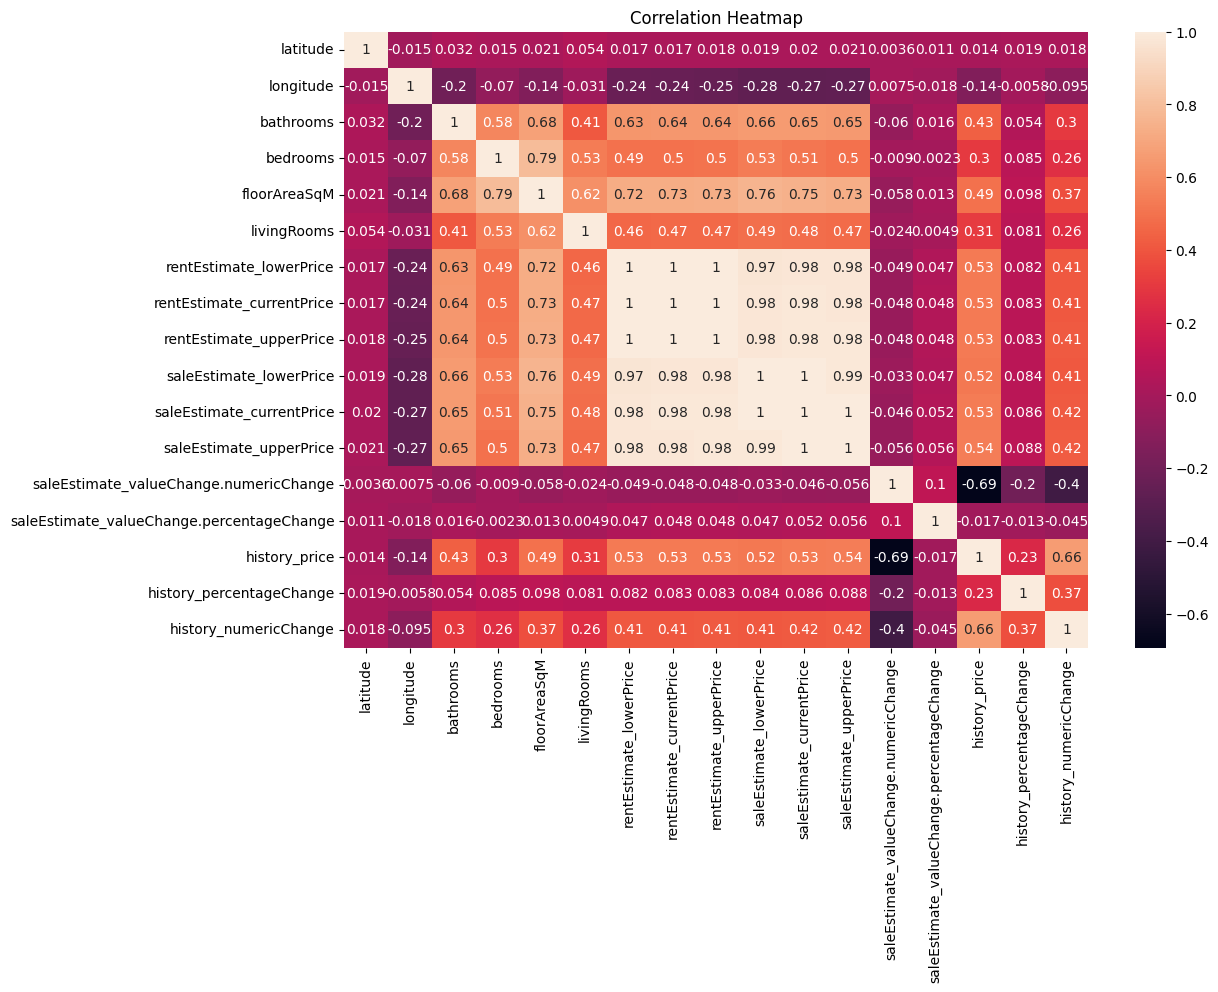

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
rent_cols = ['rentEstimate_lowerPrice', 'rentEstimate_currentPrice', 'rentEstimate_upperPrice']
df[rent_cols + ['saleEstimate_currentPrice']].corr()


,rentEstimate_lowerPrice,rentEstimate_currentPrice,rentEstimate_upperPrice,saleEstimate_currentPrice
rentEstimate_lowerPrice,1.000000,0.999734,0.999153,0.976990
rentEstimate_currentPrice,0.999734,1.000000,0.999813,0.981187
rentEstimate_upperPrice,0.999153,0.999813,1.000000,0.984309
saleEstimate_currentPrice,0.976990,0.981187,0.984309,1.000000


In [ ]:
cols_to_drop = [
    'fullAddress',
    'country',
    'saleEstimate_lowerPrice',
    'saleEstimate_upperPrice',
    'saleEstimate_confidenceLevel',
    'saleEstimate_ingestedAt',
    'saleEstimate_valueChange.numericChange',
    'saleEstimate_valueChange.percentageChange',
    'saleEstimate_valueChange.saleDate',
    'history_percentageChange',
    'history_numericChange',
    'history_price',
    'rentEstimate_lowerPrice',
    'rentEstimate_upperPrice',
    'rentEstimate_currentPrice',
]
df = df.drop(columns=cols_to_drop)

In [ ]:
df.duplicated().sum()

np.int64(5409)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.isnull().sum()

,0
postcode,0
outcode,0
latitude,0
longitude,0
bathrooms,76716
bedrooms,39733
floorAreaSqM,24741
livingRooms,59446
tenure,11245
propertyType,1119


In [ ]:
df.isnull().mean() * 100

,0
postcode,0.000000
outcode,0.000000
latitude,0.000000
longitude,0.000000
bathrooms,18.584662
bedrooms,9.625429
floorAreaSqM,5.993575
livingRooms,14.400957
tenure,2.724132
propertyType,0.271081


In [ ]:
nulls_to_drop = ['saleEstimate_currentPrice', 'tenure', 'propertyType']

df = df.dropna(subset=nulls_to_drop)

def grouped_median_impute(df, column, groupby=['propertyType', 'postcode']):
    df.loc[:, column] = df[column].fillna(df.groupby(groupby)[column].transform('median'))
    df.loc[:, column] = df[column].fillna(df[column].median())
    return df

df = grouped_median_impute(df, 'bathrooms')
df = grouped_median_impute(df, 'bedrooms')
df = grouped_median_impute(df, 'floorAreaSqM')
df = grouped_median_impute(df, 'livingRooms')

df['currentEnergyRating'] = df['currentEnergyRating'].fillna('Unknown')



In [ ]:
df = df.drop(columns=['postcode', 'outcode'])

In [ ]:
df.isnull().sum()

,0
latitude,0
longitude,0
bathrooms,0
bedrooms,0
floorAreaSqM,0
livingRooms,0
tenure,0
propertyType,0
currentEnergyRating,0
saleEstimate_currentPrice,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400893 entries, 0 to 418200
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   latitude                   400893 non-null  float64
 1   longitude                  400893 non-null  float64
 2   bathrooms                  400893 non-null  float64
 3   bedrooms                   400893 non-null  float64
 4   floorAreaSqM               400893 non-null  float64
 5   livingRooms                400893 non-null  float64
 6   tenure                     400893 non-null  object 
 7   propertyType               400893 non-null  object 
 8   currentEnergyRating        400893 non-null  object 
 9   saleEstimate_currentPrice  400893 non-null  float64
 10  history_date               400893 non-null  object 
dtypes: float64(7), object(4)
memory usage: 36.7+ MB


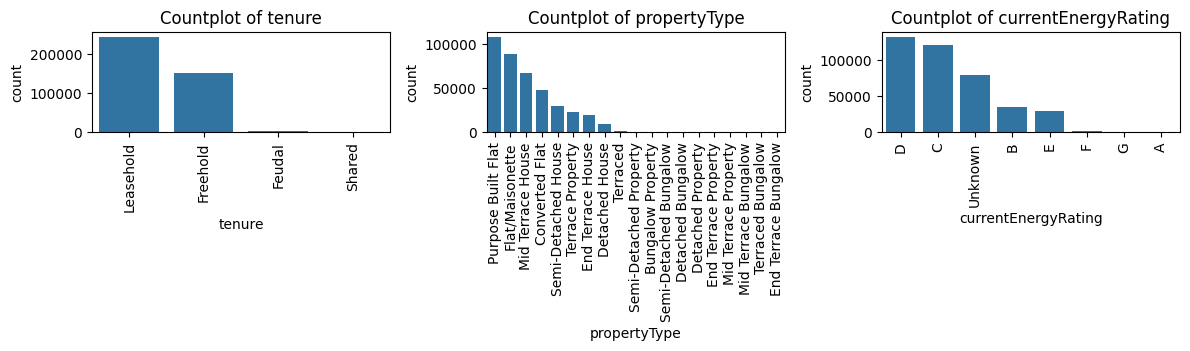

In [ ]:
cat_cols = ['tenure', 'propertyType', 'currentEnergyRating']

plt.figure(figsize=(12, 8))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=df[col], data=df, order=df[col].value_counts().index)
    plt.title(f'Countplot of {col}')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
numeric_cols = ['latitude', 'longitude', 'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms', 'saleEstimate_currentPrice']

df[numeric_cols].describe()

,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,saleEstimate_currentPrice
count,400893.000000,400893.000000,400893.000000,400893.000000,400893.000000,400893.000000,4.008930e+05
mean,51.507381,-0.101423,1.419301,2.441038,98.887858,1.259533,9.074602e+05
std,0.056374,0.087082,0.703726,1.141605,55.601228,0.556304,9.253768e+05
min,51.385708,-0.347055,1.000000,1.000000,10.000000,1.000000,8.900000e+04
25%,51.464008,-0.156106,1.000000,2.000000,63.000000,1.000000,4.470000e+05
50%,51.501117,-0.108183,1.000000,2.000000,84.000000,1.000000,6.240000e+05
75%,51.548872,-0.043276,2.000000,3.000000,115.000000,1.000000,9.870000e+05
max,51.665823,0.139249,9.000000,9.000000,500.000000,9.000000,2.922000e+07


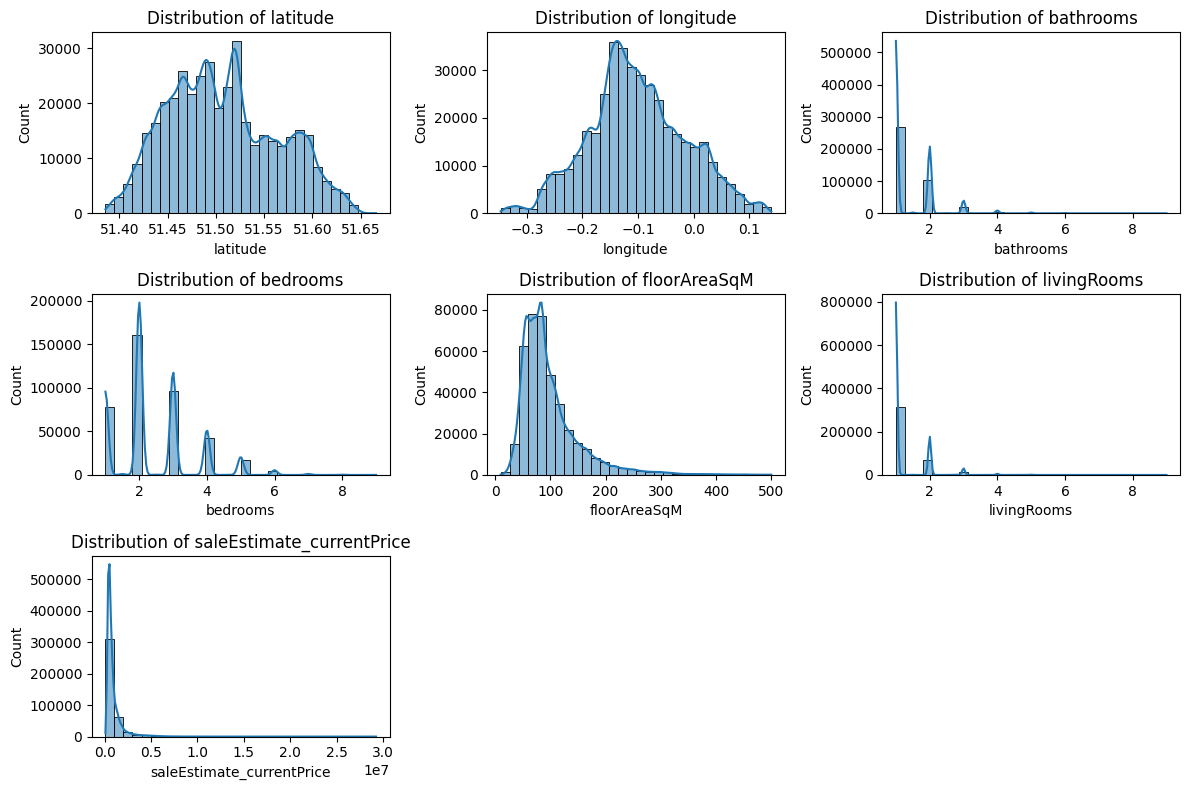

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(x=df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

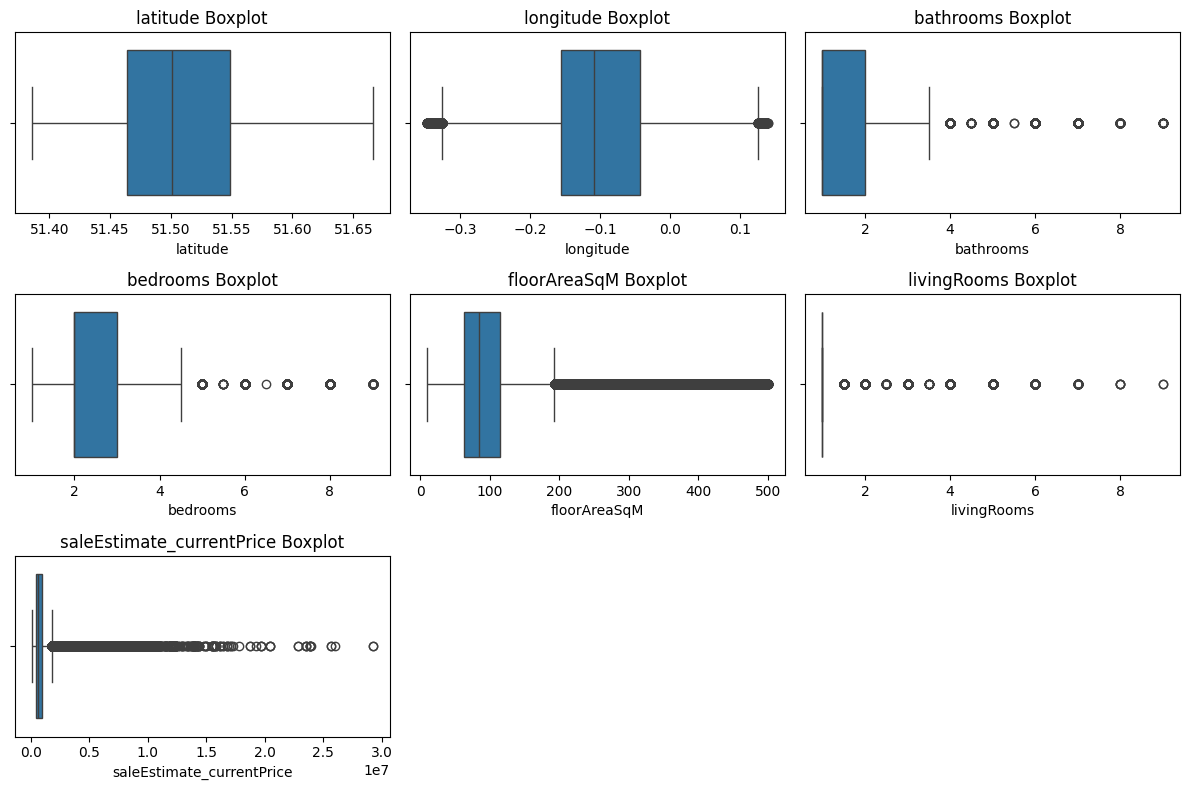

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f"{col} Boxplot")
plt.tight_layout()
plt.show()

In [ ]:
def process_outliers(df, columns=None, lower_q=0.005, upper_q=0.995, add_flags=True):
    df = df.copy()

    exclude_cols = ['latitude', 'longitude']
    if columns is None:
        columns = df.select_dtypes(include='number').columns.tolist()
        columns = [col for col in columns if col not in exclude_cols]

    for col in columns:
        lower = df[col].quantile(lower_q)
        upper = df[col].quantile(upper_q)

        # if add_flags:
        #     df[f'{col}_is_capped'] = ((df[col] < lower) | (df[col] > upper)).astype(int)

        df[col] = df[col].clip(lower=lower, upper=upper)

    for col in ['saleEstimate_currentPrice', 'floorAreaSqM']:
        if col in df.columns:
            df[f'{col}_log'] = np.log1p(df[col])

    return df

df = process_outliers(df)

In [ ]:
df.describe()

,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,saleEstimate_currentPrice,saleEstimate_currentPrice_log,floorAreaSqM_log
count,400893.000000,400893.000000,400893.000000,400893.000000,400893.000000,400893.000000,4.008930e+05,400893.000000,400893.000000
mean,51.507381,-0.101423,1.416493,2.436801,98.641151,1.257246,8.979585e+05,13.460785,4.486758
std,0.056374,0.087082,0.685519,1.125291,54.051489,0.541450,8.393073e+05,0.640482,0.462710
min,51.385708,-0.347055,1.000000,1.000000,28.000000,1.000000,2.050000e+05,12.230770,3.367296
25%,51.464008,-0.156106,1.000000,2.000000,63.000000,1.000000,4.470000e+05,13.010316,4.158883
50%,51.501117,-0.108183,1.000000,2.000000,84.000000,1.000000,6.240000e+05,13.343907,4.442651
75%,51.548872,-0.043276,2.000000,3.000000,115.000000,1.000000,9.870000e+05,13.802426,4.753590
max,51.665823,0.139249,5.000000,6.000000,368.000000,4.000000,6.024000e+06,15.611262,5.910797


In [ ]:
df['bed_bath_ratio'] = df['bedrooms'] / (df['bathrooms'] + 1e-3)
df['history_date'] = pd.to_datetime(df['history_date'])
df['history_year'] = df['history_date'].dt.year
df['history_month'] = df['history_date'].dt.month
df['history_dayofweek'] = df['history_date'].dt.dayofweek

df = df.drop(columns=['history_date'])

In [ ]:
numeric_features = [
    "latitude", "longitude", "bathrooms", "bedrooms",
    "livingRooms", "floorAreaSqM_log", "bed_bath_ratio",
    "history_year", "history_month", "history_dayofweek"
]

categorical_features = ["tenure", "propertyType", "currentEnergyRating"]


X = df[numeric_features + categorical_features]
y = df["saleEstimate_currentPrice_log"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_features])
X_test_num = scaler.transform(X_test[numeric_features])

encoder = OneHotEncoder(handle_unknown="ignore")
X_train_cat = encoder.fit_transform(X_train[categorical_features]).toarray()
X_test_cat = encoder.transform(X_test[categorical_features]).toarray()

X_train_proc = np.hstack([X_train_num, X_train_cat])
X_test_proc = np.hstack([X_test_num, X_test_cat])


lr_model = LinearRegression()
lr_model.fit(X_train_proc, y_train)

xgb_model = XGBRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42
)
xgb_model.fit(X_train_proc, y_train)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

In [ ]:
print("Linear Regression:", evaluate_model(lr_model, X_test_proc, y_test))
print("XGBoost:", evaluate_model(xgb_model, X_test_proc, y_test))

Linear Regression: {'MAE': 0.26609689392182667, 'RMSE': np.float64(0.3541459028786129), 'R2': 0.6938176836746226}
XGBoost: {'MAE': 0.1438611439379546, 'RMSE': np.float64(0.1991161690573964), 'R2': 0.9032103952043872}


In [ ]:
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

from sklearn.metrics import r2_score

y_pred = xgb_model.predict(X_test_proc)
r2 = r2_score(y_test, y_pred)

n = X_test_proc.shape[0]
p = X_test_proc.shape[1]

adj_r2 = adjusted_r2(r2, n, p)
print(f"R²: {r2:.5f}")
print(f"Adjusted R²: {adj_r2:.5f}")

R²: 0.90321
Adjusted R²: 0.90316
